## Support Vector Machine 실습코드

 https://www.kaggle.com/fengdanye/machine-learning-4-support-vector-machine
 
 위 사이트 및 12기 박진혁님 의 코드를 참조하였습니다.

# 1. SVM 시각화

In [1]:
# generate dataset
# make moon은 달모양의 데이터 분포를 생성해주는 함수입니다. 달모양 데이터가 어떻게 분류되는지 봅시당
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

X,y=make_moons(noise=0.1, random_state=2) # 반달 두 개 엎어 놓은 모양의 데이터 분포를 형성해주는 라이브러리
data = pd.DataFrame(data = X, columns=['x1','x2']) # x 데이터는 2차원
data['y']=y #타겟변수 분리
data.head()

,x1,x2,y
0,1.327241,-0.222425,1
1,-0.429116,1.071136,0
2,0.014901,0.003679,1
3,0.000352,1.087226,0
4,0.676553,0.857039,0


In [2]:
#Support Vector Machine은 스케일링이 필수라고 보시면 됩니다. ('거리'라는 요소를 사용하는 KNN SVM 등은 Scaling을 해주셔야 합니다)
scaler = StandardScaler() #정규화를 하자!
Xstan = scaler.fit_transform(X) # 스케일링을 해주자!

In [3]:
from sklearn.metrics.pairwise import rbf_kernel 

In [4]:
svc=SVC(kernel='linear', C = 100) #linear한 SVM 적용 해보자 에러페널티는 높게주고
svc.fit(Xstan,y) # 모델 트레이닝 하는 코드

SVC(C=100, kernel='linear')

In [5]:
#https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
#공식문서에 있는 hyperplane 그려주는 method를 약간 수정한 함수
def draw_hyperplane(model, X, y):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=50,
            linewidth=1, facecolors='none', edgecolors='k')
    plt.xlabel('x1', fontsize = 18)
    plt.ylabel('x2', fontsize = 18)
    plt.show()

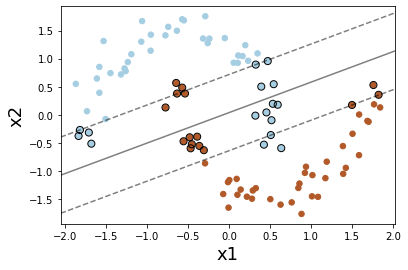

In [6]:
draw_hyperplane(svc,Xstan,y) #굵은 부분은 서포트벡터 + 에러난 벡터 

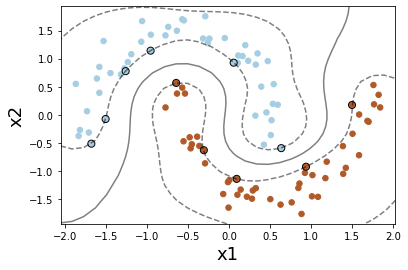

In [7]:
#case for gaussian kernel C = 100 : overfitting
svc_2=SVC(kernel='rbf', gamma = 1, C = 100)
svc_2.fit(Xstan,y)
draw_hyperplane(svc_2,Xstan,y)

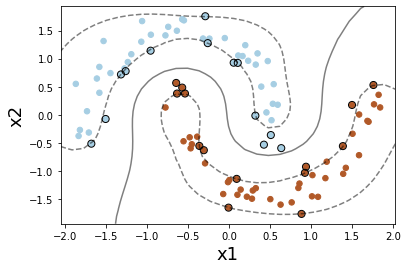

In [8]:
#case for gaussian kernel C = 1 : underfitting
svc_2=SVC(kernel='rbf', gamma = 1, C = 1)
svc_2.fit(Xstan,y)
draw_hyperplane(svc_2,Xstan,y)

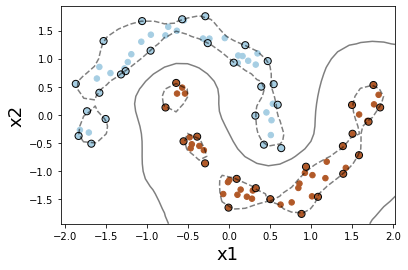

In [9]:
#case for gaussian kernel gamma = 5 : overfitting
svc_2=SVC(kernel='rbf', gamma = 5, C = 1)
svc_2.fit(Xstan,y)
draw_hyperplane(svc_2,Xstan,y)

# 2. 예측 실습

### 2.1 데이터 로드 및 확인

In [10]:
SN_ad = pd.read_csv('SN_ad.csv')

In [11]:
SN_ad.describe(include = 'all')

,User ID,Gender,Age,EstimatedSalary,Purchased
count,4.000000e+02,400,400.000000,400.000000,400.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,204,NaN,NaN,NaN
mean,1.569154e+07,NaN,37.655000,69742.500000,0.357500
std,7.165832e+04,NaN,10.482877,34096.960282,0.479864
min,1.556669e+07,NaN,18.000000,15000.000000,0.000000
25%,1.562676e+07,NaN,29.750000,43000.000000,0.000000
50%,1.569434e+07,NaN,37.000000,70000.000000,0.000000
75%,1.575036e+07,NaN,46.000000,88000.000000,1.000000


In [12]:
SN_ad.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [13]:
#총 라벨 수 확인
print("Total number of labels: {}".format(SN_ad.shape[0]))
print("Number of male: {}".format(SN_ad[SN_ad.Purchased == 0].shape[0]))
print("Number of female: {}".format(SN_ad[SN_ad.Purchased == 1].shape[0]))

Total number of labels: 400
Number of male: 257
Number of female: 143


### 2.2 간단한 데이터 전처리

In [14]:
#쓸모없는 User ID 정보 삭제
SN_ad = SN_ad.drop('User ID',axis = 1)

In [15]:
SN_ad.sample(5)

,Gender,Age,EstimatedSalary,Purchased
51,Female,18,44000,0
281,Male,35,61000,0
155,Female,31,15000,0
104,Female,19,21000,0
186,Female,20,82000,0


In [16]:
#Male Female을 숫자로
def transform_to_integer(x):
    if x=='Male':
        return 0
    elif x=='Female':
        return 1

In [17]:
SN_ad['Gender'] = SN_ad['Gender'].apply(transform_to_integer)

In [18]:
X = SN_ad.iloc[:,:-1] # X
y = SN_ad.iloc[:,-1] # y

In [19]:
print(y)

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    0
399    1
Name: Purchased, Length: 400, dtype: int64


In [20]:
#거리를 쓰는 데이터는? 스케일링해 주는 것이 좋다!
scaler = StandardScaler()
X = scaler.fit_transform(X)

### 2.3 train, test 데이터셋 분리

In [21]:
#데이터 셋 분리 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

In [22]:
from sklearn import metrics #model evaluation하는 라이브러리
svc=SVC(kernel='linear') # linear model
svc.fit(X_train,y_train) # model training
y_pred=svc.predict(X_test) # 훈련한 모델로 test셋을 시험
print('Accuracy Score:') 
print(metrics.accuracy_score(y_test,y_pred)) #스코어

Accuracy Score:
0.825


In [23]:
svc_rbf=SVC(kernel='rbf', gamma = 1) #rbf kernel
svc_rbf.fit(X_train,y_train) # model training
y_pred=svc_rbf.predict(X_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
0.875


In [24]:
from tqdm import tqdm
from sklearn.model_selection import cross_validate
C_range=list(np.arange(1,80,1)) # C값은 1부터 80까지 1간격
acc_score = [] # 결과 보관할 list

#cross validation도 해보자
for c in tqdm(C_range): 
    svc = SVC(kernel='rbf', C=c, gamma = 'scale') #gamma에 default 값을 scale로 안해주면 워닝이 어마무시하게 뜬다..!
    scores = cross_validate(svc, X, y, cv=10, scoring='accuracy') # 점수를 리스트로 관리
    score = np.mean(scores['test_score']) #10개 스코어 값의 평균
    acc_score.append(score) 
print(np.max(acc_score)) #제일 좋은 결과
print(C_range[np.argmax(acc_score)]) #제일 좋은 결과가 나온 파라미터

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.19it/s]

0.905
1


Text(0, 0.5, 'Cross-Validated Accuracy')

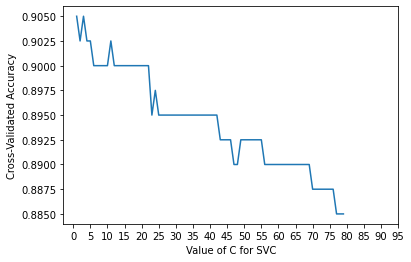

In [25]:
C_range=list(np.arange(1,80,1))
plt.plot(C_range,acc_score)
plt.xticks(np.arange(0,100,5))
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')

In [26]:
C_range=list(np.arange(1,30,0.1))
acc_score = []
for c in tqdm(C_range):
    svc = SVC(kernel='rbf',gamma = 'scale', C=c)
    svc.fit(X_train,y_train)
    scores = cross_validate(svc, X, y, cv=10, scoring='accuracy') # 점수를 리스트로 관리해줍니다.
    score = np.mean(scores['test_score']) #10개 스코어 값의 평균
    acc_score.append(score) 
print(np.max(acc_score)) #제일 좋은 결과
print(C_range[np.argmax(acc_score)]) #제일 좋은 결과가 나온 파라미터

100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [00:21<00:00, 13.66it/s]

0.9075
4.3000000000000025


Text(0, 0.5, 'Accuracy')

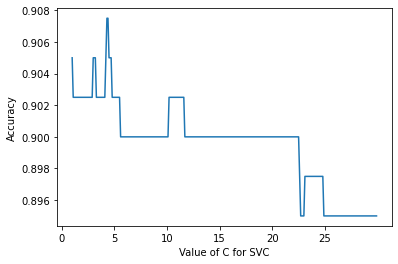

In [27]:
# 각 하이퍼 파라미터 별로 값이 얼만지 그려서 확인해보자
C_range=list(np.arange(1,30,0.1))
plt.plot(C_range,acc_score)
plt.xticks(np.arange(0,30,5))
plt.xlabel('Value of C for SVC')
plt.ylabel('Accuracy')

In [28]:
C_range[np.argmax(acc_score)]

4.3000000000000025

In [29]:
tuned_parameters = {
 'C': (np.arange(3,5,0.2)), 'kernel': ['linear'],
 'C': (np.arange(3,5,0.2)), 'gamma': (np.arange(1,5.1)), 'kernel': ['rbf']
                   }

In [30]:
from sklearn.model_selection import GridSearchCV
svm_model= SVC()
model_svm = GridSearchCV(svm_model, tuned_parameters,cv=10,scoring='accuracy', verbose = 3)
# 모델과 tuned parameter를 집어넣음! 그리고 verbose는 진행상황을 나타내주는 파라미터로 크면클수록 정보를많이줌
# 이건 default로 두면 > 데이터셋 커지는 경우에 내 코드/컴퓨터/파이썬 중 뭐가 이상한건지 찾기 힘들어집니다

In [31]:
model_svm.fit(X_train, y_train)
print(model_svm.best_score_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 2/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 3/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 4/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 5/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 6/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 7/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 8/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 9/10] END ..................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 10/10] END .................C=3.0, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 1/10] END ..................C=3.0, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 2/10] END ..................C=3.0, gamma=2

[CV 3/10] END ...C=3.4000000000000004, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 4/10] END ...C=3.4000000000000004, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 5/10] END ...C=3.4000000000000004, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 6/10] END ...C=3.4000000000000004, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 7/10] END ...C=3.4000000000000004, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 8/10] END ...C=3.4000000000000004, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 9/10] END ...C=3.4000000000000004, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 10/10] END ..C=3.4000000000000004, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 1/10] END ...C=3.4000000000000004, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 2/10] END ...C=3.4000000000000004, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 3/10] END ...C=3.4000000000000004, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 4/10] END ...C=3.4000000000000004, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 5/10] END ...C=3.4000000

[CV 6/10] END ...C=3.8000000000000007, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 7/10] END ...C=3.8000000000000007, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 8/10] END ...C=3.8000000000000007, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 9/10] END ...C=3.8000000000000007, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 10/10] END ..C=3.8000000000000007, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 1/10] END ...C=3.8000000000000007, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 2/10] END ...C=3.8000000000000007, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 3/10] END ...C=3.8000000000000007, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 4/10] END ...C=3.8000000000000007, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 5/10] END ...C=3.8000000000000007, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 6/10] END ...C=3.8000000000000007, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 7/10] END ...C=3.8000000000000007, gamma=3.0, kernel=rbf; total time=   0.0s
[CV 8/10] END ...C=3.8000000

[CV 7/10] END ....C=4.200000000000001, gamma=4.0, kernel=rbf; total time=   0.0s
[CV 8/10] END ....C=4.200000000000001, gamma=4.0, kernel=rbf; total time=   0.0s
[CV 9/10] END ....C=4.200000000000001, gamma=4.0, kernel=rbf; total time=   0.0s
[CV 10/10] END ...C=4.200000000000001, gamma=4.0, kernel=rbf; total time=   0.0s
[CV 1/10] END ....C=4.200000000000001, gamma=5.0, kernel=rbf; total time=   0.0s
[CV 2/10] END ....C=4.200000000000001, gamma=5.0, kernel=rbf; total time=   0.0s
[CV 3/10] END ....C=4.200000000000001, gamma=5.0, kernel=rbf; total time=   0.0s
[CV 4/10] END ....C=4.200000000000001, gamma=5.0, kernel=rbf; total time=   0.0s
[CV 5/10] END ....C=4.200000000000001, gamma=5.0, kernel=rbf; total time=   0.0s
[CV 6/10] END ....C=4.200000000000001, gamma=5.0, kernel=rbf; total time=   0.0s
[CV 7/10] END ....C=4.200000000000001, gamma=5.0, kernel=rbf; total time=   0.0s
[CV 8/10] END ....C=4.200000000000001, gamma=5.0, kernel=rbf; total time=   0.0s
[CV 9/10] END ....C=4.200000

[CV 5/10] END ....C=4.800000000000002, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 6/10] END ....C=4.800000000000002, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 7/10] END ....C=4.800000000000002, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 8/10] END ....C=4.800000000000002, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 9/10] END ....C=4.800000000000002, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 10/10] END ...C=4.800000000000002, gamma=1.0, kernel=rbf; total time=   0.0s
[CV 1/10] END ....C=4.800000000000002, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 2/10] END ....C=4.800000000000002, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 3/10] END ....C=4.800000000000002, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 4/10] END ....C=4.800000000000002, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 5/10] END ....C=4.800000000000002, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 6/10] END ....C=4.800000000000002, gamma=2.0, kernel=rbf; total time=   0.0s
[CV 7/10] END ....C=4.800000

In [32]:
print(model_svm.best_params_) # 최고의 결과가 나온 경우

{'C': 3.0, 'gamma': 3.0, 'kernel': 'rbf'}


In [33]:
svm_temp = SVC(kernel = 'rbf', gamma = 3.0, C = 3.0)

In [34]:
svm_temp.fit(X_train,y_train)
y_pred = svm_temp.predict(X_test) # 훈련한 모델로 test셋을 시험해보자
print('Accuracy Score:') 
print(metrics.accuracy_score(y_test,y_pred)) #스코어 확인

Accuracy Score:
0.85
